## Data preparation and legacy algorithm implementing

In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install pycm

In [8]:
!pip install torch

    100% |████████████████████████████████| 676.9MB 133kB/s ta 0:00:0101 2% |▊                               | 14.6MB 2.5MB/s eta 0:04:25    4% |█▍                              | 28.8MB 2.8MB/s eta 0:03:53    4% |█▍                              | 30.5MB 1.6MB/s eta 0:06:44    20% |██████▍                         | 135.7MB 732kB/s eta 0:12:20    20% |██████▌                         | 138.3MB 587kB/s eta 0:15:18    20% |██████▋                         | 140.7MB 756kB/s eta 0:11:49    24% |███████▉                        | 165.5MB 1.2MB/s eta 0:07:10    28% |█████████▎                      | 195.5MB 794kB/s eta 0:10:06�████████▎                    | 238.5MB 143.9MB/s eta 0:00:04    35% |███████████▌                    | 243.5MB 773kB/s eta 0:09:21    56% |██████████████████              | 381.4MB 462kB/s eta 0:10:39    60% |███████████████████▍            | 409.1MB 2.2MB/s eta 0:02:03 160.8MB/s eta 0:00:02�█▉         | 483.5MB 165.2MB/s eta 0:00:02    88% |████████████████████████████▏   

In [3]:
!pip install obspy

In [371]:
import os
fileList = os.listdir('/home/chen/Downloads/SegyData')

In [372]:
print(fileList)

['Inline_3223_orig.sgy', 'Xline_1543_orig.sgy', 'Xline_1693_orig.sgy', 'Inline_3473_orig.sgy', 'Xline_1493_orig.sgy', 'Inline_3373_orig.sgy']


In [4]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print('Running on GPU')
    device = 'cuda'
else:
    print('Running on CPU')

Running on CPU


In [363]:
from obspy.io.segy.segy import _read_segy

stream = _read_segy('/home/chen/Downloads/SegyData/Inline_3473_orig.sgy', headonly=True)

In [364]:
stream

1916 traces in the SEG Y structure.

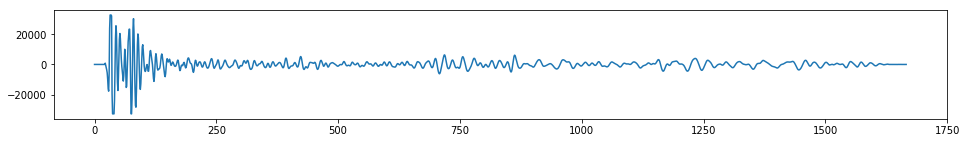

In [365]:
one_trace = stream.traces[0]

plt.figure(figsize=(16,2))
plt.plot(one_trace.data)
plt.show()

In [366]:
stream.traces[0].data.shape

(1667,)

In [367]:
fig1 = []
for i in range(len(stream.traces)):
    fig1.append(stream.traces[i].data)
fig1 = np.array(fig1)
fig1 = fig1.T
print(fig1.shape)

(1667, 1916)


In [368]:
vm = np.percentile(fig1, 99)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm, fig1.max()))

The 99th percentile is 10603; the max amplitude is 32767


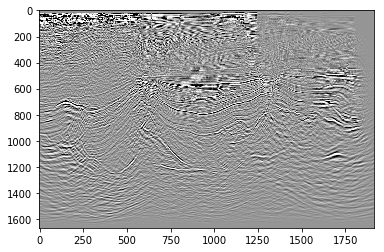

In [369]:
plt.imshow(fig1, cmap="Greys", vmin=-vm, vmax=vm, aspect='auto')

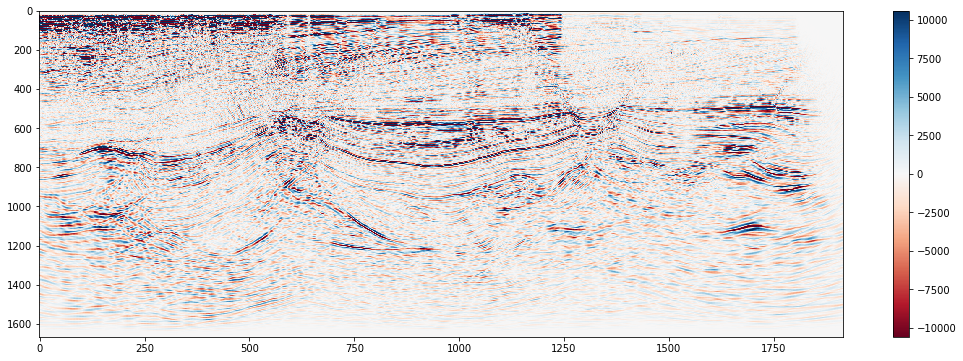

In [370]:
plt.figure(figsize=(18,6))
plt.imshow(fig1, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto')
plt.colorbar()
plt.show()

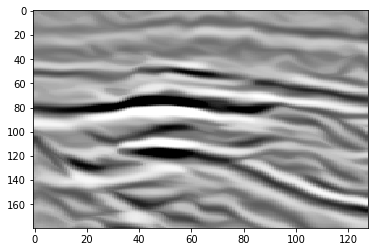

In [46]:
plt.imshow(fig1[620:800,:128],cmap="Greys", vmin=-vm, vmax=vm, aspect='auto')

In [27]:
print(fig1[:,1750:])
print(np.count_nonzero(fig1[:, 1750:]))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
266540


In [69]:
print(fig1)

[[ 0.          0.          0.         ...,  0.          0.
   0.        ]
 [ 0.          0.          0.         ...,  0.          0.
   0.        ]
 [ 0.          0.          0.         ...,  0.          0.
   0.        ]
 ..., 
 [-0.34823483  0.233109    1.386281   ...,  0.          0.
   0.        ]
 [-1.4278507  -1.5649738  -1.4704733  ...,  0.          0.
   0.        ]
 [ 0.02543347  0.0478363  -0.05864307 ...,  0.          0.
   0.        ]]


In [94]:
print(fig1[128:256,:128])

[[-2811.0872  -2421.9844  -1905.0457  ...,  1697.7356   1317.5957
    815.57324]
 [-2867.061   -2993.6392  -2811.      ...,  1796.4873   1726.6912
   1890.6091 ]
 [-1175.3616  -1511.3059  -1958.1465  ...,  1870.8308   1783.2463
   1787.7004 ]
 ..., 
 [ -686.65625  -659.2368  -1024.373   ..., -2799.2769  -2390.711
  -1733.9426 ]
 [ 1140.3335    958.86255   493.2871  ..., -2299.6438  -1504.3096
   -777.20264]
 [ 1315.1069   1549.9585   1370.4211  ..., -1217.5999   -446.9646
    454.60645]]


In [98]:
def normalisation(figs):
    figs = figs.float()
    mean = torch.mean(figs)
    std = torch.std(figs)
    figs -= mean
    figs /= std
    print(mean)
    print(std)
    return figs

In [95]:
figs = torch.Tensor(fig1)

In [99]:
figs = normalisation(figs)

tensor(16.0191)
tensor(3374.4468)


In [106]:
print(figs)

tensor([[-0.0047, -0.0047, -0.0047,  ..., -0.0047, -0.0047, -0.0047],
        [-0.0047, -0.0047, -0.0047,  ..., -0.0047, -0.0047, -0.0047],
        [-0.0047, -0.0047, -0.0047,  ..., -0.0047, -0.0047, -0.0047],
        ...,
        [-0.0049, -0.0047, -0.0043,  ..., -0.0047, -0.0047, -0.0047],
        [-0.0052, -0.0052, -0.0052,  ..., -0.0047, -0.0047, -0.0047],
        [-0.0047, -0.0047, -0.0048,  ..., -0.0047, -0.0047, -0.0047]])


In [107]:
print(figs[128:256,:128])

tensor([[-0.8378, -0.7225, -0.5693,  ...,  0.4984,  0.3857,  0.2369],
        [-0.8544, -0.8919, -0.8378,  ...,  0.5276,  0.5069,  0.5555],
        [-0.3531, -0.4526, -0.5850,  ...,  0.5497,  0.5237,  0.5250],
        ...,
        [-0.2082, -0.2001, -0.3083,  ..., -0.8343, -0.7132, -0.5186],
        [ 0.3332,  0.2794,  0.1414,  ..., -0.6862, -0.4505, -0.2351],
        [ 0.3850,  0.4546,  0.4014,  ..., -0.3656, -0.1372,  0.1300]])


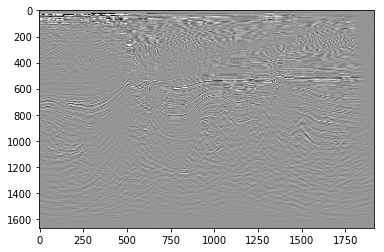

In [108]:
plt.imshow(figs, cmap="Greys", aspect='auto')

In [110]:
def train(model, optimizer, criterion, data_loader):
    model.train() # train model mode
    train_loss, train_accuracy = 0, 0 #instantiate return variables
    for X, y in data_loader: #iterate over data in batch size
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() #reset optimizer gradients
        a2 = model(X.view(X.size(0), 1, 28, 28)).to(device) # predict for current data the model(x) value
        loss = criterion(a2, y.long()) #compute the loss by computing the criterion(y_prediction, y_real)
        loss.backward()  #perform backpropagation
        train_loss += loss*X.size(0) # keep track of loss
        y_pred = F.log_softmax(a2, dim=1).max(1)[1] # apply softmax layer to prediction
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # check for accuracy
        optimizer.step()  # step on gradient descent 
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval() #model evaluation
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad(): # no optimisierr or stepping
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(X.size(0), 1, 28, 28)).to(device) # predict for current data the model(x) value
            loss = criterion(a2, y.long()) #compute the loss by computing the criterion(y_prediction, y_real)
            validation_loss += loss*X.size(0)# keep track of loss
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # apply softmax layer to prediction
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # check and track accuracy
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)


In [ ]:
shuffler = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 0)
shuffler.get_n_splits(figs, labels)

In [109]:
criterion = nn.CrossEntropyLoss()
seed = 42
lr = 1e-2
mom = 0.05
batch_size = 128
test_batch_size = 1000
n_epoches = 80
w_decay = 0.0

In [ ]:
figs_train = TensorDataset(figs, labels)

In [ ]:
class LegacyNet(nn.Module):
    def __init__(self):
        super(LegacyNet, self).__init__()
        self.linear1 = nn.Linear(16, 8)
        self.batchnorm = nn.Batchnorm1d(8)
        self.linear2 = nn.Linear(8, 6)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        z1 = self.linear1(x)
        a1 = self.dropout(self.activation(self.batchnorm(z1)))
        z2 = self.linear2(a1)
        return z2

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.C1 = nn.Conv2d(1, 6, kernel_size = 5, padding = 2) #Convolution C1 
        self.S2 = nn.MaxPool2d(kernel_size=2, stride=2) # Pooling S2  
        self.C3 = nn.Conv2d(6, 16, 5, stride = 1) #Convolution C3   
        self.S4 = nn.MaxPool2d(kernel_size=2, stride=2) # Pooling S4   
        self.C5 = nn.Linear((5*5*16), 120) # Fully Connected Layer C5
        self.F6 = nn.Linear(120, 84) # Fully Connected Layer F6
        self.output = nn.Linear(84, 10) # Output layer for softmax
        self.A = nn.ReLU() # Activation Layer
        #self.drop = nn.Dropout()
    
    def forward(self, x):
        x = self.A(self.C1(x))
        x = self.A(self.S2(x))
        x = self.A(self.C3(x))
        x = self.A(self.S4(x))
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
        x = self.A(self.C5(x))
        x = self.A(self.F6(x))
        
    return self.output(x)


In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1) #new dimensions
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.batchnorm2 = nn.BatchNorm2d(192)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.batchnorm4 = nn.BatchNorm2d(384)
        self.batchnorm5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.batchnorm7 = nn.BatchNorm2d(64)

        self.fc6 = nn.Linear(64*3*3, 288)
        self.batchnorm8 = nn.BatchNorm1d(288)
        self.fc7 = nn.Linear(288, 100)
        self.batchnorm9 = nn.BatchNorm1d(100)
        self.fc8 = nn.Linear(100, 10)
        
        self.dropout = nn.Dropout()
        
        self.activation = nn.ReLU()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.activation(x)
        x = self.pool1(x)
        
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.pool2(x)
        
        
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.activation(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.activation(x)
        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = self.activation(x)
        x = self.pool3(x)
        
        
        x = self.conv6(x)
        x = self.batchnorm6(x)
        x = self.activation(x)
        x = self.conv7(x)
        x = self.batchnorm7(x)
        x = self.activation(x)
        
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
        x = self.fc6(x)
        x = self.batchnorm8(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc7(x)
        x = self.batchnorm9(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc8(x)
        return x

In [ ]:
# For training and validation purposes
def train_model_liveloss(X_train, y_train, lr_=lr, w_decay_=w_decay, n_epochs_=n_epochs, rmsprop=False):
    set_seed(seed) # set random seed
    model = AlexNet().to(device) #instantiate model
    if not rmsprop:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr_, betas=(0.9, 0.999), eps=1e-08, weight_decay=w_decay) # Instantiate Optimiser
    elif rmsprop:
        optimizer = torch.optim.RMSprop(model.parameters())  #The optimizer we used for the second model
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience = 8)
  
    liveloss = PlotLosses() #LiveLoss Plot for visuals
  
    for epoch in range(n_epochs_): #iterate over number of epochs    
        kmnist_train = CustomImageTensorDataset(X_train, y_train, transform=train_transform) # Transform data (mutation set as hyperparameter = 50%)
        train_loader = DataLoader(kmnist_train, batch_size = batch_size, shuffle = True, num_workers = 4) # create Train Loader
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader) #train model using training data loader
        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, val_loader) # validate model using validation data loader
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw() ## plote LiveLoss plot
        if rmsprop:
            scheduler.step(validation_loss.item())
      
    return model

In [113]:
import xlrd

In [221]:
data1 = xlrd.open_workbook('Exercices.xlsx')

In [222]:
sheetname = 'Exo01_ResB'
table = data1.sheet_by_name(sheetname)
nrows = table.nrows
ncols = table.ncols
attB = []
poB = []
PHIB = []

for i in range(2, nrows):
    rowV = table.row_values(i)
    att = []
    po = []
    PHI = []
    for j in range(3, 13):
        att.append(rowV[j])
    for k in range(13, 33):
        po.append(rowV[k])
    for m in range(33, 53):
        PHI.append(rowV[m])
    attB.append(att)
    poB.append(np.mean(np.array(po)))
    PHIB.append(np.mean(np.array(PHI)))

print(len(attB))
print(len(attB[0]))
    

5183
10


In [224]:
x_data = Variable(torch.from_numpy(np.array(attB))).float()
y_data_po = Variable(torch.from_numpy(np.array(poB))).float()
y_data_PHI = Variable(torch.from_numpy(np.array(PHIB))).float()

In [225]:
train_x_data = x_data[:4000]
train_po_data = y_data_po[:4000]
train_PHI_data = y_data_PHI[:4000]

val_x_data = x_data[4000:4500]
val_po_data = x_data[4000:4500]
val_pHI_data = x_data[4000:4500]

test_x_data = x_data[4500:]
test_po_data = x_data[4500:]
test_pHI_data = x_data[4500:]

In [277]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.l1 = nn.Linear(10,6)
        self.l2 = nn.Linear(6,4)
        self.l3 = nn.Linear(4,1)
        
    def forward(self,x):
        x = self.l1(x)
        x = self.l2(x)
        y_pred = self.l3(x)
        return y_pred

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1,self).__init__()
        self.l1 = nn.Linear(10,6)
        self.l2 = nn.Linear(6,4)
        self.l3 = nn.Linear(4,1)
        self.dropout = nn.Dropout()
        
    def forward(self,x):
        x = self.dropout(self.l1(x))
        x = self.dropout(self.l2(x))
        y_pred = self.l3(x)
        return y_pred

In [344]:
def train(model, optimizer, criterion, x_train, y_train):
    model.train() # train model mode
    train_loss = 0. #instantiate return variables
    for i in range(len(x_train)): #iterate over data in batch size
        X, y = x_train[i].to(device), y_train[i].to(device)
        optimizer.zero_grad() #reset optimizer gradients
        a2 = model(X).to(device) # predict for current data the model(x) value
        loss = criterion(a2, y) #compute the loss by computing the criterion(y_prediction, y_real)
        loss.backward()  #perform backpropagation
        train_loss += loss*X.size(0) # keep track of loss
        y_pred = a2 # apply softmax layer to prediction
        optimizer.step()  # step on gradient descent 
        
    return train_loss/len(x_train)
  
def validate(model, criterion, x_val, y_val):
    model.eval() #model evaluation
    validation_loss = 0.
    for i in range(len(x_val)):
        with torch.no_grad(): # no optimisierr or stepping
            X, y = x_val[i].to(device), y_val[i].to(device)
            a2 = model(X).to(device) # predict for current data the model(x) value
            loss = criterion(a2, y) #compute the loss by computing the criterion(y_prediction, y_real)
            validation_loss += loss*X.size(0)# keep track of loss
            y_pred = a2
            
    return validation_loss/len(x_val)

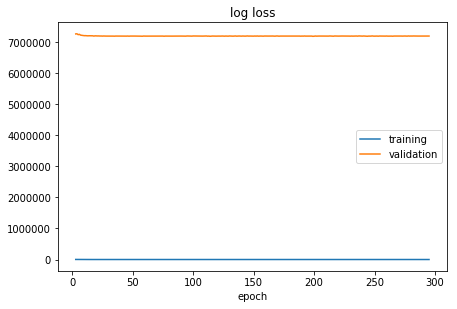

log loss:
training   (min:  260.944, max: 78492.812, cur:  267.639)
validation (min: 7189140.500, max: 7312250.000, cur: 7197876.500)


KeyboardInterrupt: 

In [347]:
model = Model1()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([-1129.62, 1313.33, 1343.06, 772.17, 976.16, -532.51, 572.33, -121.68, 970.52, -356.75
]))

result_n = []
ite = 0
liveloss = PlotLosses()

for epoch in range(100):
    logs = {}
    train_loss = train(model, optimizer, criterion, train_x_data, train_po_data) #train model using training data loader
    logs['' + 'log loss'] = train_loss.item()
    #logs['' + 'accuracy'] = 0

    validation_loss = validate(model, criterion, val_x_data, val_po_data) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    #logs['val_' + 'accuracy'] = 0

    liveloss.update(logs)
    liveloss.draw() ## plote LiveLoss plot

print(ite)
print(model.forward(t_var).data[0])

In [282]:
model = Model()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([-1129.62, 1313.33, 1343.06, 772.17, 976.16, -532.51, 572.33, -121.68, 970.52, -356.75
]))

result_n = []
ite = 0

for epoch in range(1000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data_po)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    if len(result_n) > 50 and abs(new_result - result_n[-40]) < 0.1:
        break
    print(model.forward(t_var).data[0])

print(ite)
print(model.forward(t_var).data[0])

tensor(-97.4239)
tensor(-90.2412)
tensor(-83.2009)
tensor(-76.3102)
tensor(-69.5736)
tensor(-62.9931)
tensor(-56.5678)
tensor(-50.2941)
tensor(-44.1666)
tensor(-38.1788)
tensor(-32.3245)
tensor(-26.5983)
tensor(-20.9963)
tensor(-15.5163)
tensor(-10.1580)
tensor(-4.9232)
tensor(0.1844)
tensor(5.1592)
tensor(9.9936)
tensor(14.6781)
tensor(19.2016)
tensor(23.5511)
tensor(27.7125)
tensor(31.6701)
tensor(35.4074)
tensor(38.9073)
tensor(42.1529)
tensor(45.1276)
tensor(47.8166)
tensor(50.2072)
tensor(52.2895)
tensor(54.0578)
tensor(55.5100)
tensor(56.6489)
tensor(57.4816)
tensor(58.0193)
tensor(58.2775)
tensor(58.2743)
tensor(58.0310)
tensor(57.5707)
tensor(56.9177)
tensor(56.0972)
tensor(55.1345)
tensor(54.0546)
tensor(52.8815)
tensor(51.6385)
tensor(50.3473)
tensor(49.0281)
tensor(47.6994)
tensor(46.3780)
tensor(45.0787)
tensor(43.8147)
tensor(42.5971)
tensor(41.4356)
tensor(40.3379)
tensor(39.3102)
tensor(38.3575)
tensor(37.4829)
tensor(36.6887)
tensor(35.9756)
tensor(35.3437)
tensor(34.79

tensor(24.7920)
tensor(24.7925)
tensor(24.7930)
tensor(24.7934)
tensor(24.7939)
tensor(24.7944)
tensor(24.7949)
tensor(24.7954)
tensor(24.7959)
tensor(24.7964)
tensor(24.7969)
tensor(24.7974)
tensor(24.7980)
tensor(24.7985)
tensor(24.7990)
tensor(24.7995)
tensor(24.8000)
tensor(24.8006)
tensor(24.8011)
tensor(24.8016)
tensor(24.8022)
tensor(24.8027)
tensor(24.8032)
tensor(24.8038)
tensor(24.8043)
tensor(24.8049)
tensor(24.8054)
tensor(24.8060)
tensor(24.8065)
tensor(24.8071)
tensor(24.8076)
tensor(24.8082)
tensor(24.8087)
tensor(24.8093)
tensor(24.8099)
tensor(24.8104)
tensor(24.8110)
tensor(24.8116)
tensor(24.8121)
tensor(24.8127)
tensor(24.8133)
tensor(24.8139)
tensor(24.8144)
tensor(24.8150)
tensor(24.8156)
tensor(24.8162)
tensor(24.8168)
tensor(24.8173)
tensor(24.8179)
tensor(24.8185)
tensor(24.8191)
tensor(24.8197)
tensor(24.8202)
tensor(24.8208)
tensor(24.8214)
tensor(24.8219)
tensor(24.8225)
tensor(24.8231)
tensor(24.8237)
tensor(24.8243)
tensor(24.8249)
tensor(24.8255)
tensor(2

In [283]:
model_save_name = 'net1po.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [286]:
print(train_PHI_data[0])

tensor(0.0231)


In [288]:
model = Model()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.01, betas = (0.8, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([-1129.62, 1313.33, 1343.06, 772.17, 976.16, -532.51, 572.33, -121.68, 970.52, -356.75
]))

result_n = []
ite = 0

for epoch in range(10000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data_PHI)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    result_n.append(new_result)
    ite += 1
    #if len(result_n) > 50 and abs(new_result - result_n[-40]) < 0.1:
    #    break

#print(ite)
    if ite % 100 == 0:
        print(model.forward(t_var).data[0])

tensor(-2.5565)
tensor(-1.3456)
tensor(-1.0975)
tensor(-0.9331)
tensor(-0.7944)
tensor(-0.6878)
tensor(-0.6096)
tensor(-0.5513)
tensor(-0.5048)
tensor(-0.4641)
tensor(-0.4256)
tensor(-0.3870)
tensor(-0.3473)
tensor(-0.3063)
tensor(-0.2638)
tensor(-0.2201)
tensor(-0.1755)
tensor(-0.1303)
tensor(-0.0850)
tensor(-0.0401)
tensor(0.0040)
tensor(0.0465)
tensor(0.0870)
tensor(0.1247)
tensor(0.1592)
tensor(0.1898)
tensor(-1.3074)
tensor(-2.0999)
tensor(-0.2580)
tensor(0.2334)
tensor(1.2041)
tensor(0.2351)
tensor(0.2499)
tensor(0.2293)
tensor(0.2340)
tensor(0.2517)
tensor(0.2224)
tensor(0.2238)
tensor(0.3819)
tensor(0.2092)
tensor(0.2101)
tensor(0.1919)
tensor(0.1932)
tensor(0.1934)
tensor(0.2087)
tensor(0.1777)
tensor(0.1778)
tensor(0.1687)
tensor(0.1626)
tensor(0.3579)
tensor(0.1479)
tensor(-0.5141)
tensor(0.1342)
tensor(0.1355)
tensor(0.1365)
tensor(0.2428)
tensor(0.1227)
tensor(0.1227)
tensor(0.1107)
tensor(0.1101)
tensor(0.1116)
tensor(-0.0150)
tensor(0.0978)
tensor(0.0997)
tensor(1.7494)


In [289]:
model_save_name = 'net1PHIE.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [303]:
model = Model()
model.load_state_dict(torch.load(path))
model.eval()

Model(
  (l1): Linear(in_features=10, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=4, bias=True)
  (l3): Linear(in_features=4, out_features=1, bias=True)
)

In [304]:
criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.001, betas = (0.8, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([-1129.62, 1313.33, 1343.06, 772.17, 976.16, -532.51, 572.33, -121.68, 970.52, -356.75
]))

result_n = []
ite = 0
gap = 0
ref = 0.0003
cnt = 0

for epoch in range(10000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    result_n.append(new_result)
    if len(result_n) > 3:
        gap = abs(new_result - result_n[-2])
        if gap <= ref:
            cnt += 1
            if cnt >= 500:
                break
        else:
            cnt = 0
    ite += 1
    

#print(ite)
    if ite % 100 == 0:
        print(model.forward(t_var).data[0])

tensor(0.0244)
tensor(0.0251)
tensor(0.0254)
tensor(0.0257)
tensor(0.0259)


In [305]:
model_save_name = 'net1PHIE.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [318]:
sheetname1 = 'Exo01_ResN'
table1 = data1.sheet_by_name(sheetname1)
nrows1 = table1.nrows
ncols1 = table1.ncols
attB1 = []
poB1 = []
PHIB1 = []

for i in range(1, nrows1-4):
    rowV = table1.row_values(i)
    att = []
    po = []
    PHI = []
    for j in range(3, 13):
        att.append(rowV[j])
    for k in range(13, 33):
        po.append(rowV[k])
    for m in range(33, 53):
        PHI.append(rowV[m])
    attB1.append(att)
    poB1.append(np.array([np.mean(np.array(po))]))
    PHIB1.append(np.array([np.mean(np.array(PHI))]))

print(len(attB1))
print(len(attB1[0]))

5184
10


In [319]:
x_data1 = Variable(torch.from_numpy(np.array(attB1))).float()
y_data_po1 = Variable(torch.from_numpy(np.array(poB1))).float()
y_data_PHI1 = Variable(torch.from_numpy(np.array(PHIB1))).float()

In [320]:
print(y_data_po1)

tensor([[13.3325],
        [12.9995],
        [12.0010],
        ...,
        [ 9.6675],
        [ 9.5010],
        [ 8.0005]])


In [323]:
model = Model()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([732.51, 1310.87, 597.62, 892.79, -366.94, 292.36, 453.83, 415.73, 132.72, -465.42]))

result_n = []
ite = 0

for epoch in range(3000):
    y_pred = model(x_data1)
    #print(y_pred)
    loss = criterion(y_pred, y_data_po1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    ite += 1
    if len(result_n) > 50 and abs(new_result - result_n[-40]) < 0.1:
        break
    print(model.forward(t_var).data[0])

print(ite)
print(model.forward(t_var).data[0])

tensor(25.0583)
tensor(23.8366)
tensor(21.9165)
tensor(19.6693)
tensor(17.3229)
tensor(15.0485)
tensor(12.9957)
tensor(11.2403)
tensor(9.7648)
tensor(8.5071)
tensor(7.3980)
tensor(6.3777)
tensor(5.4054)
tensor(4.4681)
tensor(3.5802)
tensor(2.7768)
tensor(2.1014)
tensor(1.5915)
tensor(1.2683)
tensor(1.1326)
tensor(1.1689)
tensor(1.3504)
tensor(1.6447)
tensor(2.0179)
tensor(2.4387)
tensor(2.8828)
tensor(3.3359)
tensor(3.7936)
tensor(4.2599)
tensor(4.7428)
tensor(5.2493)
tensor(5.7816)
tensor(6.3349)
tensor(6.8971)
tensor(7.4500)
tensor(7.9733)
tensor(8.4478)
tensor(8.8596)
tensor(9.2028)
tensor(9.4796)
tensor(9.6993)
tensor(9.8740)
tensor(10.0158)
tensor(10.1330)
tensor(10.2288)
tensor(10.3014)
tensor(10.3456)
tensor(10.3558)
tensor(10.3287)
tensor(10.2654)
tensor(10.1721)
tensor(10.0591)
tensor(9.9385)
tensor(9.8219)
tensor(9.7179)
tensor(9.6309)
tensor(9.5607)
tensor(9.5045)
tensor(9.4583)
tensor(9.4191)
tensor(9.3862)
tensor(9.3621)
tensor(9.3510)
tensor(9.3576)
tensor(9.3858)
tensor(

tensor(14.6056)
tensor(14.6098)
tensor(14.6140)
tensor(14.6182)
tensor(14.6224)
tensor(14.6266)
tensor(14.6308)
tensor(14.6350)
tensor(14.6392)
tensor(14.6435)
tensor(14.6477)
tensor(14.6519)
tensor(14.6561)
tensor(14.6603)
tensor(14.6645)
tensor(14.6687)
tensor(14.6729)
tensor(14.6771)
tensor(14.6814)
tensor(14.6856)
tensor(14.6898)
tensor(14.6940)
tensor(14.6982)
tensor(14.7024)
tensor(14.7066)
tensor(14.7109)
tensor(14.7151)
tensor(14.7193)
tensor(14.7235)
tensor(14.7277)
tensor(14.7320)
tensor(14.7362)
tensor(14.7404)
tensor(14.7446)
tensor(14.7489)
tensor(14.7531)
tensor(14.7573)
tensor(14.7615)
tensor(14.7658)
tensor(14.7700)
tensor(14.7742)
tensor(14.7784)
tensor(14.7827)
tensor(14.7869)
tensor(14.7911)
tensor(14.7954)
tensor(14.7996)
tensor(14.8038)
tensor(14.8081)
tensor(14.8123)
tensor(14.8166)
tensor(14.8208)
tensor(14.8250)
tensor(14.8293)
tensor(14.8335)
tensor(14.8378)
tensor(14.8420)
tensor(14.8463)
tensor(14.8505)
tensor(14.8548)
tensor(14.8590)
tensor(14.8633)
tensor(1

tensor(17.2933)
tensor(17.2992)
tensor(17.3051)
tensor(17.3110)
tensor(17.3170)
tensor(17.3229)
tensor(17.3287)
tensor(17.3347)
tensor(17.3406)
tensor(17.3464)
tensor(17.3523)
tensor(17.3583)
tensor(17.3642)
tensor(17.3700)
tensor(17.3759)
tensor(17.3818)
tensor(17.3877)
tensor(17.3936)
tensor(17.3994)
tensor(17.4053)
tensor(17.4112)
tensor(17.4170)
tensor(17.4230)
tensor(17.4288)
tensor(17.4347)
tensor(17.4405)
tensor(17.4464)
tensor(17.4523)
tensor(17.4581)
tensor(17.4639)
tensor(17.4698)
tensor(17.4756)
tensor(17.4814)
tensor(17.4873)
tensor(17.4931)
tensor(17.4989)
tensor(17.5047)
tensor(17.5106)
tensor(17.5164)
tensor(17.5222)
tensor(17.5280)
tensor(17.5338)
tensor(17.5396)
tensor(17.5454)
tensor(17.5512)
tensor(17.5569)
tensor(17.5627)
tensor(17.5685)
tensor(17.5742)
tensor(17.5800)
tensor(17.5857)
tensor(17.5915)
tensor(17.5972)
tensor(17.6030)
tensor(17.6087)
tensor(17.6145)
tensor(17.6201)
tensor(17.6259)
tensor(17.6316)
tensor(17.6373)
tensor(17.6430)
tensor(17.6487)
tensor(1

tensor(19.0231)
tensor(19.0240)
tensor(19.0241)
tensor(19.0253)
tensor(19.0253)
tensor(19.0264)
tensor(19.0266)
tensor(19.0275)
tensor(19.0280)
tensor(19.0285)
tensor(19.0293)
tensor(19.0295)
tensor(19.0305)
tensor(19.0307)
tensor(19.0316)
tensor(19.0319)
tensor(19.0327)
tensor(19.0332)
tensor(19.0337)
tensor(19.0344)
tensor(19.0348)
tensor(19.0355)
tensor(19.0359)
tensor(19.0366)
tensor(19.0370)
tensor(19.0376)
tensor(19.0381)
tensor(19.0387)
tensor(19.0392)
tensor(19.0397)
tensor(19.0403)
tensor(19.0408)
tensor(19.0413)
tensor(19.0418)
tensor(19.0424)
tensor(19.0429)
tensor(19.0434)
tensor(19.0439)
tensor(19.0444)
tensor(19.0450)
tensor(19.0454)
tensor(19.0459)
tensor(19.0464)
tensor(19.0470)
tensor(19.0474)
tensor(19.0479)
tensor(19.0484)
tensor(19.0489)
tensor(19.0494)
tensor(19.0499)
tensor(19.0504)
tensor(19.0508)
tensor(19.0513)
tensor(19.0518)
tensor(19.0523)
tensor(19.0527)
tensor(19.0532)
tensor(19.0536)
tensor(19.0542)
tensor(19.0545)
tensor(19.0551)
tensor(19.0555)
tensor(1

tensor(19.1774)
tensor(19.1527)
tensor(19.1774)
tensor(19.1592)
tensor(19.1677)
tensor(19.1704)
tensor(19.1587)
tensor(19.1763)
tensor(19.1580)
tensor(19.1733)
tensor(19.1647)
tensor(19.1658)
tensor(19.1722)
tensor(19.1609)
tensor(19.1745)
tensor(19.1623)
tensor(19.1712)
tensor(19.1677)
tensor(19.1661)
tensor(19.1725)
tensor(19.1636)
tensor(19.1734)
tensor(19.1653)
tensor(19.1708)
tensor(19.1693)
tensor(19.1674)
tensor(19.1725)
tensor(19.1661)
tensor(19.1730)
tensor(19.1674)
tensor(19.1712)
tensor(19.1702)
tensor(19.1690)
tensor(19.1725)
tensor(19.1681)
tensor(19.1730)
tensor(19.1689)
tensor(19.1721)
tensor(19.1708)
tensor(19.1706)
tensor(19.1726)
tensor(19.1698)
tensor(19.1733)
tensor(19.1702)
tensor(19.1730)
tensor(19.1714)
tensor(19.1721)
tensor(19.1728)
tensor(19.1714)
tensor(19.1736)
tensor(19.1714)
tensor(19.1738)
tensor(19.1721)
tensor(19.1734)
tensor(19.1731)
tensor(19.1729)
tensor(19.1739)
tensor(19.1728)
tensor(19.1744)
tensor(19.1730)
tensor(19.1744)
tensor(19.1736)
tensor(1

tensor(19.2102)
tensor(19.2100)
tensor(19.2102)
tensor(19.2103)
tensor(19.2102)
tensor(19.2106)
tensor(19.2103)
tensor(19.2108)
tensor(19.2105)
tensor(19.2109)
tensor(19.2107)
tensor(19.2110)
tensor(19.2110)
tensor(19.2111)
tensor(19.2112)
tensor(19.2112)
tensor(19.2114)
tensor(19.2113)
tensor(19.2116)
tensor(19.2114)
tensor(19.2117)
tensor(19.2116)
tensor(19.2118)
tensor(19.2118)
tensor(19.2120)
tensor(19.2120)
tensor(19.2121)
tensor(19.2122)
tensor(19.2122)
tensor(19.2124)
tensor(19.2123)
tensor(19.2125)
tensor(19.2125)
tensor(19.2127)
tensor(19.2126)
tensor(19.2128)
tensor(19.2128)
tensor(19.2129)
tensor(19.2130)
tensor(19.2131)
tensor(19.2131)
tensor(19.2132)
tensor(19.2133)
tensor(19.2133)
tensor(19.2134)
tensor(19.2134)
tensor(19.2136)
tensor(19.2136)
tensor(19.2138)
tensor(19.2137)
tensor(19.2139)
tensor(19.2138)
tensor(19.2141)
tensor(19.2140)
tensor(19.2142)
tensor(19.2141)
tensor(19.2144)
tensor(19.2142)
tensor(19.2145)
tensor(19.2143)
tensor(19.2147)
tensor(19.2144)
tensor(1

In [324]:
model_save_name = 'net2po.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [332]:
model = Model1()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.01, betas = (0.8, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([732.51, 1310.87, 597.62, 892.79, -366.94, 292.36, 453.83, 415.73, 132.72, -465.42]))


result_n = []
ite = 0
gap = 0
ref = 0.0003
cnt = 0

for epoch in range(10000):
    y_pred = model(x_data1)
    loss = criterion(y_pred, y_data_PHI1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    result_n.append(new_result)
    if len(result_n) > 3:
        gap = abs(new_result - result_n[-2])
        if gap <= ref:
            cnt += 1
            if cnt >= 1000:
                break
        else:
            cnt = 0
    ite += 1
    

#print(ite)
    if ite % 100 == 0:
        print(model.forward(t_var).data[0])

tensor(-2.3280)
tensor(3.4753)
tensor(3.9661)
tensor(0.8847)
tensor(2.2559)
tensor(0.4566)
tensor(3.9086)
tensor(-1.7525)
tensor(-3.6016)
tensor(-4.5981)
tensor(1.1922)
tensor(1.5001)
tensor(2.5148)
tensor(0.8681)
tensor(-0.5502)
tensor(0.0798)
tensor(0.3969)
tensor(0.5330)
tensor(0.0115)
tensor(-1.3193)
tensor(-0.2296)
tensor(0.0017)
tensor(0.3926)
tensor(0.0344)
tensor(-0.0223)
tensor(0.0295)
tensor(0.1711)
tensor(-0.0315)
tensor(0.0356)
tensor(0.0257)
tensor(0.0528)
tensor(0.0127)
tensor(0.0294)
tensor(0.0203)
tensor(0.0249)
tensor(0.0241)
tensor(0.0233)
tensor(0.0236)
tensor(0.0244)
tensor(0.0245)
tensor(0.0263)
tensor(0.0244)
tensor(0.0250)
tensor(0.0252)
tensor(0.0243)
tensor(0.0247)
tensor(0.0243)
tensor(0.0245)
tensor(0.0234)
tensor(0.0238)
tensor(0.0244)
tensor(0.0244)
tensor(0.0242)
tensor(0.0236)
tensor(0.0252)
tensor(0.0253)
tensor(0.0244)
tensor(0.0244)
tensor(0.0247)
tensor(0.0245)
tensor(0.0251)
tensor(0.0238)
tensor(0.0253)
tensor(0.0244)
tensor(0.0239)
tensor(0.0250)
t

In [334]:
model_save_name = 'net2PHIE.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [373]:
path = F'/home/chen/Downloads/net1po.pt'
model = Model()
model.load_state_dict(torch.load(path))
model.eval()

Model(
  (l1): Linear(in_features=10, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=4, bias=True)
  (l3): Linear(in_features=4, out_features=1, bias=True)
)

In [383]:
t_var = x_data
gap = []
for i in range(len(t_var)):
    pred = model.forward(t_var[i]).data[0]
    gap1 = abs(pred - y_data_po[i])
    gap.append(torch.Tensor.numpy(gap1))

In [385]:
print(np.array(gap))

[ 8.520489   3.9042187  7.965103  ...,  1.7492504  2.106985   2.1069393]


In [386]:
gap = np.array(gap)
print(np.mean(gap))

4.5116


In [387]:
print(np.std(gap))

4.31914
